## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string, re, unicodedata, contractions, nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lelouvincx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/lelouvincx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lelouvincx/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lelouvincx/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Load the dataset

In [4]:
# Get the data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MYrgpfuyfJKPorxCPl8MFzzrgPgtMJlX' -O data_resume.csv -q

In [5]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('data_resume.csv')

# Display the first few rows of the DataFrame
print(f"Shape of the DataFrame: {df.shape}")
df.head()

Shape of the DataFrame: (962, 2)


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


## Explolatory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [7]:
# Check for missing values
df.isna().sum()

Category    0
Resume      0
dtype: int64

In [8]:
# Check for duplicate rows
df.duplicated().sum()

796

In [9]:
# There're many duplicated rows in the dataset. Let's remove them.
df.drop_duplicates(inplace=True)

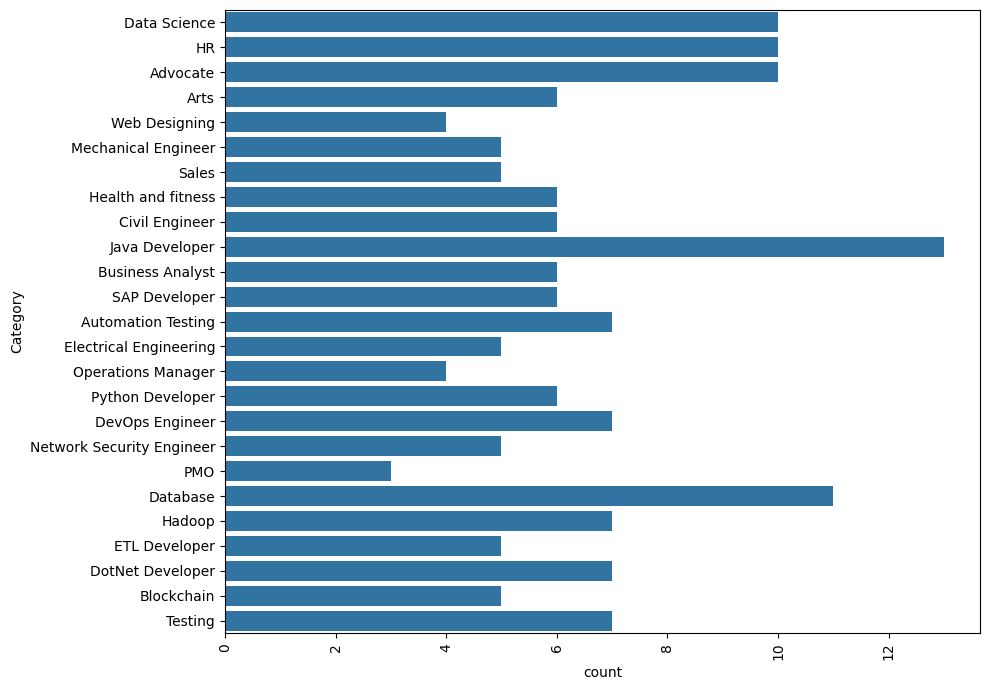

In [10]:
# Create figure 
fig = plt.figure(figsize =(10, 7))
sns.countplot(df.Category)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
print(f"Total number of available jobs: {df.Category.nunique()}")

Total number of available jobs: 25


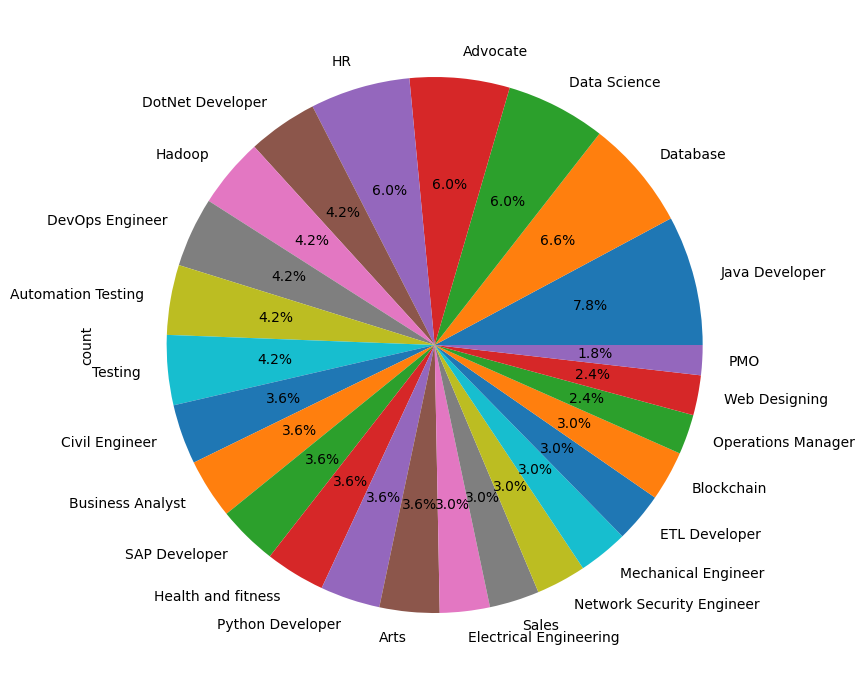

In [12]:
# Create pie chart for the distribution of the job categories
fig = plt.figure(figsize =(10, 7))
df.Category.value_counts().plot.pie(autopct='%1.1f%%')
plt.tight_layout()
plt.show()

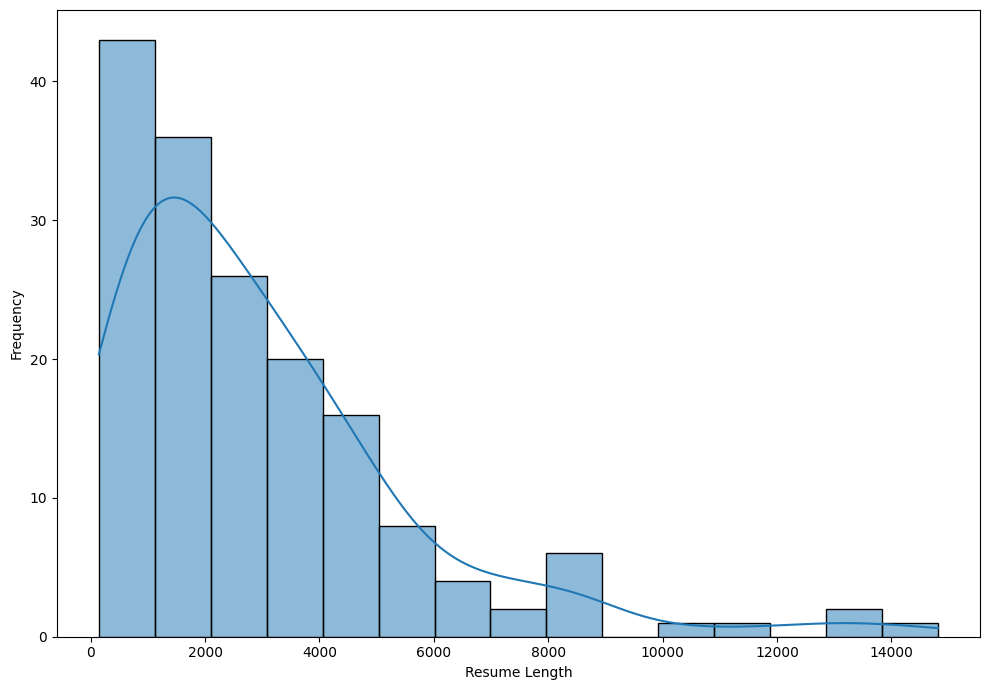

In [13]:
fig = plt.figure(figsize =(10, 7))
df['resume_len'] = df.Resume.apply(len)
sns.histplot(df.resume_len, kde=True)
plt.xlabel('Resume Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [14]:
df.describe()

,resume_len
count,166.000000
mean,2980.114458
std,2646.110439
min,142.000000
25%,1036.000000
50%,2361.000000
75%,3886.500000
max,14816.000000


In [15]:
# Set max resume length
max_len = 200

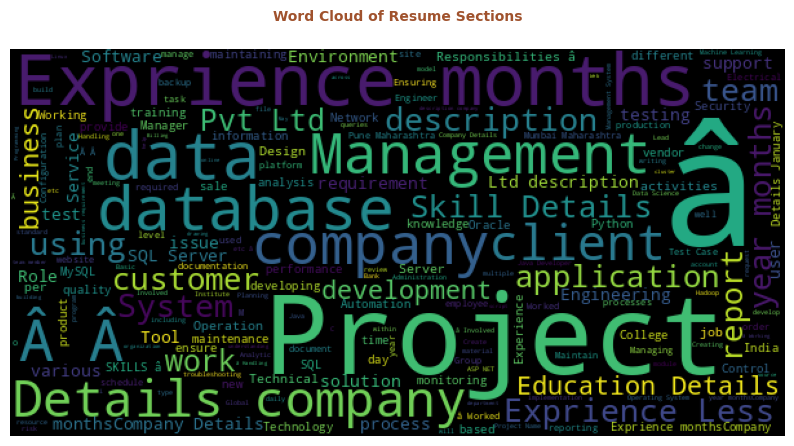

In [16]:
fig = plt.figure(figsize=(10, 7))
wc = WordCloud(width=600, height=300, random_state=101).generate(' '.join(df.Resume))
plt.title(label='Word Cloud of Resume Sections', pad=20, fontsize=10, fontweight='bold', color='sienna')
plt.imshow(wc)
plt.axis('off')
plt.show()

## Encoding the target labels i.e. all available jobs

In [17]:
df.head()

,Category,Resume,resume_len
0,Data Science,Skills * Programming Languages: Python (pandas...,4786
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,1268
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",1871
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,6995
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",452


In [18]:
labels_dict = {}

for idx, label in enumerate(df.Category.unique()):
    labels_dict[label] = idx

labels_dict

{'Data Science': 0,
 'HR': 1,
 'Advocate': 2,
 'Arts': 3,
 'Web Designing': 4,
 'Mechanical Engineer': 5,
 'Sales': 6,
 'Health and fitness': 7,
 'Civil Engineer': 8,
 'Java Developer': 9,
 'Business Analyst': 10,
 'SAP Developer': 11,
 'Automation Testing': 12,
 'Electrical Engineering': 13,
 'Operations Manager': 14,
 'Python Developer': 15,
 'DevOps Engineer': 16,
 'Network Security Engineer': 17,
 'PMO': 18,
 'Database': 19,
 'Hadoop': 20,
 'ETL Developer': 21,
 'DotNet Developer': 22,
 'Blockchain': 23,
 'Testing': 24}

In [19]:
df.Category = df.Category.apply(func=lambda x: labels_dict[x])
df.Category = df.Category.astype(np.int64)

## Text preprocessing

In [20]:
# Remove HTML tags
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

# Remove underscores
def remove_underscore(text):
    return text.replace('_', ' ')

# Remove digits
def remove_digits(text):
    return re.sub(r'\d+', '', text)

# Remove redundant urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in word_tokenize(text) if word.lower() not in stop_words])

# Remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Remove contracted words
def expand_contractions(text):
    return contractions.fix(text)

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(lambda text: self.preprocess_text(text))

    def preprocess_text(self, text):
        text = text.lower()
        text = remove_html_tags(text)
        text = remove_underscore(text)
        text = remove_digits(text)
        text = remove_urls(text)
        text = remove_punctuation(text)
        text = remove_emojis(text)
        text = expand_contractions(text)
        text = re.sub('http\S+\s*', ' ', text)  # remove URLs
        text = re.sub('RT|cc', ' ', text)  # remove RT and cc
        text = re.sub('#\S+', '', text)  # remove hashtags
        text = re.sub('@\S+', '  ', text)  # remove mentions
        text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~â¢Ââ"""), ' ', text)  # remove punctuations
        text = re.sub(r'[^\x00-\x7f]',r' ', text)
        text = re.sub('\s+', ' ', text)  # remove extra whitespace
        return text

In [22]:
text_preprocessor = TextPreprocessor()
df['cleaned_resume'] = text_preprocessor.fit_transform(df['Resume'])

print(f"Shape of the DataFrame: {df.shape}")
df.head()

Shape of the DataFrame: (166, 4)


,Category,Resume,resume_len,cleaned_resume
0,0,Skills * Programming Languages: Python (pandas...,4786,skills programming languages python pandas num...
1,0,Education Details \r\nMay 2013 to May 2017 B.E...,1268,education details may to may be uitrgpv data s...
2,0,"Areas of Interest Deep Learning, Control Syste...",1871,areas of interest deep learning control system...
3,0,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,6995,skills are python sap hana tableau sap hana sq...
4,0,"Education Details \r\n MCA YMCAUST, Faridab...",452,education details mca ymcaust faridabad haryan...


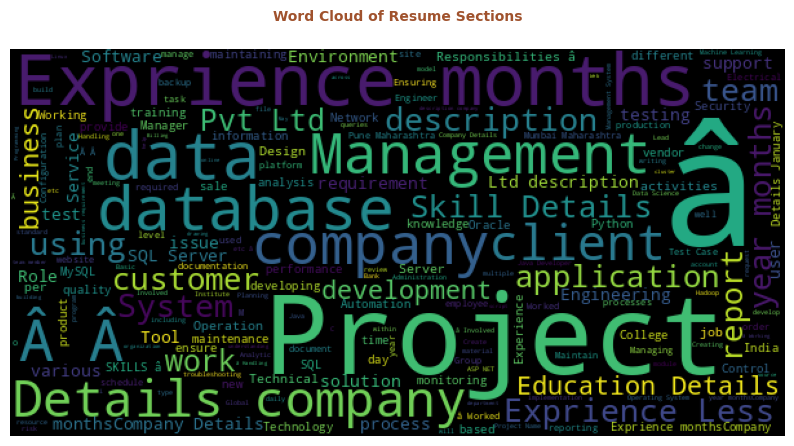

In [23]:
fig = plt.figure(figsize=(10, 7))
wc = WordCloud(width=600, height=300, random_state=101).generate(' '.join(df.Resume))
plt.title(label='Word Cloud of Resume Sections', pad=20, fontsize=10, fontweight='bold', color='sienna')
plt.imshow(wc)
plt.axis('off')
plt.show()

## Download the pretrained tokenizer and BERT + SBERT models

In [24]:
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
import torch
from torch.nn import CosineSimilarity

In [25]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [26]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [27]:
# If GPU is available, move the model to the GPU
if torch.cuda.is_available():
    bert_model = bert_model.cuda()
    sbert_model = sbert_model.cuda()

## Text tokenization

In [28]:
max_resume_len = 200

In [29]:
def encode_text_bert(text):
    with torch.no_grad():
        # Tokenize the input text
        inputs = tokenizer(text, add_special_tokens=True, truncation=True, 
                                max_length=max_resume_len, padding=True, return_tensors='pt')
        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}
        # Pass the tokenized input to the model
        outputs = bert_model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        mean_hidden_states = last_hidden_states.mean(dim=1)
    return mean_hidden_states

def encode_text_sbert(text):
    with torch.no_grad():
        embeddings = sbert_model.encode(text, convert_to_tensor=True)
    return embeddings

In [30]:
def calculate_similarity(model, encoded_job, encoded_resumes):
    cosine_sim = CosineSimilarity(dim=1)
    return cosine_sim(encoded_job, encoded_resumes)

In [31]:
# Example job description
job_description = """
We are seeking a skilled and motivated Java Developer to join our development team. The ideal candidate will have a strong background in Java programming, a passion for technology, and a drive to create high-quality software solutions. As a Java Developer, you will be responsible for designing, developing, and maintaining Java applications, ensuring their performance, scalability, and reliability.
In this role, you will design, develop, and maintain Java applications and systems. You will write well-designed, efficient, and testable code and participate in all phases of the software development lifecycle. Analyzing user requirements to define business objectives and collaborating with cross-functional teams to define and design new features will be essential parts of your job. Additionally, you will conduct software analysis, programming, testing, and debugging, ensuring that designs comply with specifications. Recommending changes to improve established Java application processes, supporting continuous improvement by investigating alternatives and technologies, performing code reviews, and mentoring junior developers will also be part of your responsibilities.
To be successful in this role, you should have a Bachelor's degree in Computer Science, Engineering, or a related field, along with proven experience as a Java Developer or in a similar role. Strong proficiency in Java, with a good understanding of its ecosystems, and experience with Java frameworks such as Spring and Hibernate are essential. Familiarity with object-oriented programming (OOP) principles and experience with front-end technologies like HTML, CSS, and JavaScript are advantageous. You should have knowledge of relational databases such as MySQL and PostgreSQL, and SQL, as well as familiarity with build tools like Maven and Gradle, and version control systems such as Git. Excellent problem-solving skills, attention to detail, strong communication, and teamwork abilities are also required.
Preferred candidates will have experience with cloud platforms such as AWS, Azure, or Google Cloud, knowledge of microservices architecture and RESTful APIs, and experience with containerization tools like Docker and Kubernetes. Familiarity with Agile/Scrum development methodologies is also a plus.
"""

In [32]:
# Encode the job description using BERT and SBERT
encoded_job_bert = encode_text_bert([job_description])
encoded_job_sbert = sbert_model.encode([job_description], convert_to_tensor=True)

# Encode the resumes using BERT and SBERT
encoded_resumes_bert = encode_text_bert(df['cleaned_resume'].tolist())
encoded_resumes_sbert = encode_text_sbert(df['cleaned_resume'].tolist())

In [33]:
# Calculate and display the similarity scores
df['similarity_bert'] = calculate_similarity(bert_model, encoded_job_bert, encoded_resumes_bert).cpu().numpy()
df['similarity_sbert'] = calculate_similarity(sbert_model, encoded_job_sbert, encoded_resumes_sbert).cpu().numpy()

# Rank the resumes based on similarity scores
df_ranked_bert = df.sort_values(by='similarity_bert', ascending=False)
df_ranked_sbert = df.sort_values(by='similarity_sbert', ascending=False)

In [34]:
# Display the top 10 resumes based on BERT similarity
df_ranked_bert[['Category', 'similarity_bert', 'Resume']].head(10)

,Category,similarity_bert,Resume
679,18,0.831526,CORE COMPETENCIES â¢ Maintain processes to en...
512,14,0.807795,KEY COMPETENCIES â¶Multi - Operations Managem...
681,18,0.806368,Skills Exceptional communication and networkin...
332,9,0.799397,Skills â¢ Language: Java â¢ Operating System...
656,17,0.795781,Communication Skills My writing skills in Engl...
455,12,0.794692,* Excellent grasping power in learning new con...
269,7,0.786913,Education Details \r\nJanuary 2009 P.G. Sports...
435,11,0.785925,Education Details \r\nJanuary 2016 Bachelor Of...
459,12,0.785730,"Technical Skills Summary I have completed ""COR..."
407,10,0.780869,TECHNOLOGICAL SKILLS â¦ Knowledge of Computer...


In [35]:
# Display the top 10 resumes based on SBERT similarity
df_ranked_sbert[['Category', 'similarity_sbert', 'Resume']].head(10)

,Category,similarity_sbert,Resume
679,18,0.816919,CORE COMPETENCIES â¢ Maintain processes to en...
551,15,0.800898,Technical Skills / Responsibilities: â¢ Hands...
329,9,0.793384,Education Details \r\nJanuary 2016 B.E Informa...
50,1,0.781190,SOFTWARE SKILLS: â¢ General Computer Proficie...
331,9,0.772906,SKILLS: - 1) Team leading 2) Self-motivated 3)...
459,12,0.771262,"Technical Skills Summary I have completed ""COR..."
332,9,0.768955,Skills â¢ Language: Java â¢ Operating System...
719,19,0.762679,"TECHNICAL SKILLS â¢ SQL â¢ Oracle v10, v11, ..."
6,0,0.752559,Skills â¢ Python â¢ Tableau â¢ Data Visuali...
435,11,0.748375,Education Details \r\nJanuary 2016 Bachelor Of...


## Model evaluation